In [2]:
%matplotlib inline

import Bayesian_Particle_Tracking
from Bayesian_Particle_Tracking import model
from Bayesian_Particle_Tracking.model import log_likelihood, log_posterior, log_prior, diffusion, displacement
from Bayesian_Particle_Tracking import io
from Bayesian_Particle_Tracking.prior import JeffreysPrior, UniformPrior
from Bayesian_Particle_Tracking.data_analysis import max_likelihood_estimation, MSD, Nind, sigma_var, CGW_analysis
from Bayesian_Particle_Tracking.generate_data import generator
import emcee
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import math

/Users/alanzhou/anaconda3/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [3]:
data = io.get_example_model('test_data.npy')

In [19]:
test_data = generator(1000,1e-8,1e-10,[0,0,0], parameter = "D")
test_data = diffusion(test_data)

In [313]:
def safe_likelihood(diffusion_object, max_value, log_lower_bound, log_upper_bound, iterations, safety_factor = 1, start_value = 0):
    D = np.logspace(log_lower_bound, log_upper_bound, iterations)
    for i in range(start_value, max_value):
        result = np.array(list(map(lambda d: likelihood(d, test_data, 10**(-i/safety_factor)), D)))
        total = np.sum(result)
        print("max: %.3e min: %.3e total: %.3e" %(result.max(), result.min(), total))
        if total > 0 and total != np.inf:
            return D, result/total, i/safety_factor
        if total == 0:
            return_value_big = i/safety_factor
            return_value_small = (i-1)/safety_factor
            print("Increase Safety Factor. Good value of safety_scale/safety_factor is between %.4e and %.4e" %(return_value_small, return_value_big))
            break
    print("max_value.")
    
    

In [321]:
def safe_likelihood(diffusion_object, max_value, log_lower_bound, log_upper_bound, iterations, safety_factor = 1, start_value = 0, safety_constant = 0):
    D = np.logspace(log_lower_bound, log_upper_bound, iterations)
    for i in range(start_value, max_value):
        result = np.array(list(map(lambda d: likelihood(d, test_data, 10**(-i/safety_factor - safety_constant)), D)))
        total = np.sum(result)
        if total > 0 and total != np.inf:
            print("max: %.3e min: %.3e total: %.3e" %(result.max(), result.min(), total))
            print("Exponent: %.4f" %(-i/safety_factor - safety_constant))
            return D, result/total, i/safety_factor - safety_constant
        if total == 0:
            return_value_big = i/safety_factor + safety_constant
            return_value_small = (i-1)/safety_factor + safety_constant
            print("Good value of (-i/safety_factor - safety_constant) is between %.4f and %.4f" %(return_value_small, return_value_big))
            return safe_likelihood(diffusion_object, max_value, log_lower_bound, log_upper_bound, iterations, safety_factor = safety_factor + 1, safety_constant = return_value_small)
    print("Did not find a safe value. Try increasing the number of iterations or changing the safety factor.")
    return None
    

In [5]:
def likelihood(theta, diffusion_object, safety_scale, unknown = 'D', known_variables = None):

    data = diffusion_object.data
    ndim = diffusion_object.dim
    sigma_m = diffusion_object.sigma_m

    #This code assumes the diffusion obeject gives absolute time instead of time displacements
    time = diffusion_object.time
    tau = time[1:len(time)] - time[0:len(time)-1]
    distance = displacement(data)

    if unknown == 'D':
        D = theta
    
    #sigma is the error on the displacement. This comes from the error propogation terms in the positional measurments, sigma1 and sigma2.
    sigma_1 = sigma_m[1:len(sigma_m)]
    sigma_2 = sigma_m[:len(sigma_m)-1]
    sigma = np.sqrt(sigma_1**2+sigma_2**2)

    diffusion_factor = np.sqrt(2*ndim*D*tau)

    result = (2*np.pi)**(-len(data)/2)*np.product(safety_scale/np.sqrt(sigma**2+diffusion_factor**2))*np.exp(np.sum(-((distance)**2)/(2*(diffusion_factor**2+sigma**2))))

    return result

In [51]:
#D, test_likelihood, scale = safe_likelihood(test_data, 100, -10.5, -9.5, 100, safety_factor = 1, start_value = 0)
D = np.logspace(-10.5,-9.5,999)
likelihood(D, test_data, 10**(-4.302361001))
#print(scale)
#print(D[np.argmax(test_likelihood)])

nan

NameError: name 'test_likelihood' is not defined

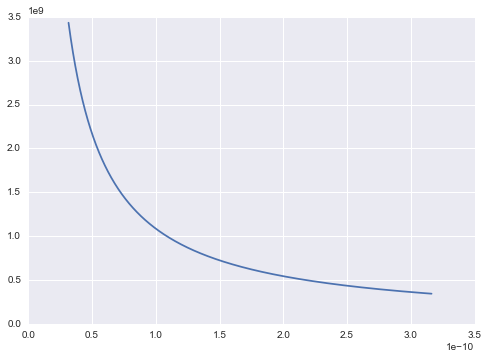

In [9]:
test_prior = np.exp(np.array(list(map(log_prior,D))))
plt.plot(D,test_prior)
test_posterior = test_prior*test_likelihood
test_posterior = test_posterior/np.sum(test_posterior)
plt.figure()
plt.plot(D, test_posterior)
print(D[np.argmax(test_posterior)])

In [191]:
D, Dbest, loglike, Dmin, Dmax = max_likelihood_estimation(test_data, -11, -9, 1000)
Dbest

9.6601747995226453e-11